# Local Climate Zone (LCZ) Identification Model - RGB Bands

This set of notebooks (2a and 2b) focuses on the fitting of the LCZ Identification Model using 2 different sets of specifications:
1. RGB Bands SENTINEL-2 images
2. All Bands (10) SENTINEL-2 images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize

import json
import glob

# additional configuration for function decorator, as TF2.0 does not have this set as True by default
# this is required for the model to fit
tf.config.run_functions_eagerly(True)

2023-05-30 07:07:34.997476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext autoreload
%autoreload 2

----

## Import Dataset

In [3]:
# load dataset - specify split if need to split into train and validation
train_ds, val_ds = tfds.load('so2sat', split=['train','validation'], as_supervised=True, download=False)

2023-05-26 00:46:47.848586: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/dsisg_yusheng/miniconda3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2023-05-26 00:46:48.008011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8]
	 [[{{node Placeholder/_2}}]]
2023-05-26 00:46:48.008364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]


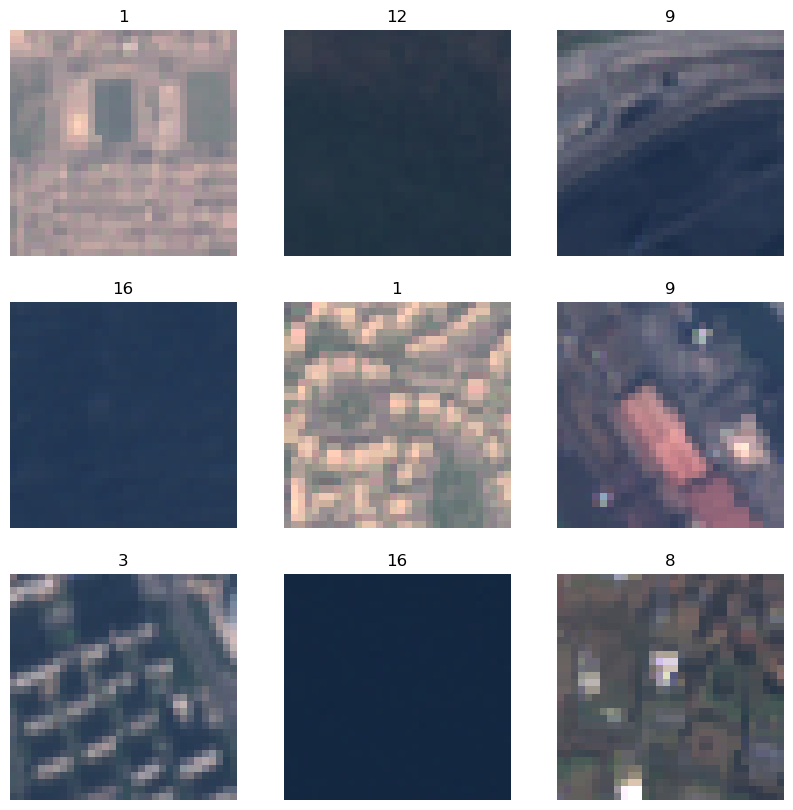

In [4]:
# check out the first 9 images of the training dataset (for fun)
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


----

## EDA

In [35]:
%%time
# extract all training labels
images, labels = tuple(zip(*train_ds))

CPU times: user 2min 48s, sys: 29 s, total: 3min 16s
Wall time: 1min 14s


In [36]:
# convert labels to array and then dataframe
labels = np.array(labels)
labels = pd.DataFrame(labels, columns = ['label'])

In [68]:
# define LCZ class list
lcz_classes = [str(i) for i in list(range(1,11))] + ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [45]:
# convert label to str for easier plotting
labels = labels.astype('category')

labels['label'] = pd.Categorical(labels['label'], 
                                 categories=[str(i) for i in list(range(0,17))],
                                 ordered=True)

In [62]:
# define style of plots
rc_params = {'axes.facecolor': '#00002E', 'axes.edgecolor': 'white',
             'figure.facecolor':'#00002E', 'axes.labelcolor': 'white',
             'xtick.color':'white', 'ytick.color':'white', 
             'axes.spines.right': False, 'axes.spines.top': False}

/tmp/ipykernel_257384/2992443359.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lcz_classes)


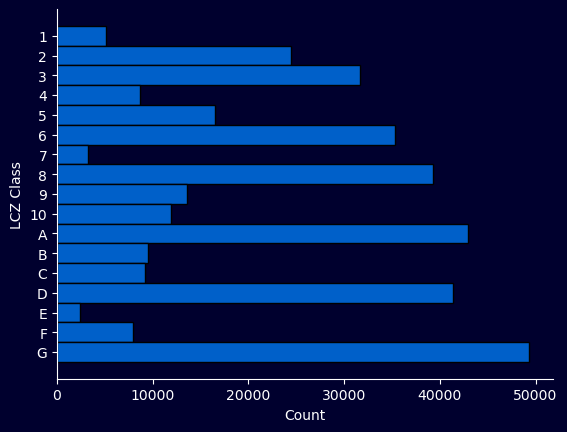

In [70]:
# plot as histogram
sns.set_style(rc = rc_params)
ax = sns.histplot(labels, y='label', discrete = True, color='#0081FE')
ax.set(ylabel='LCZ Class')
ax.set_yticklabels(lcz_classes)

plt.show()

----

## Import Pretrained ResNet50 Model

In [23]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))

base_model.trainable= False

### Reconfigure ResNet50 for RGB Band LCZ Identification Model

In [24]:
# create new model on top
inputs = tf.keras.Input(shape=(32, 32, 3))


In [25]:
# build full model
x = base_model(inputs, training=False)
x = layers.Dense(1000, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
predictions = layers.Dense(17, activation='softmax')(x)

model_resnet50 = Model(inputs=inputs, outputs=predictions)

In [26]:
model_resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_2 (Dense)             (None, 1, 1, 1000)        2049000   
                                                                 
 global_average_pooling2d_1   (None, 1000)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 17)                17017     
                                                                 
Total params: 25,653,729
Trainable params: 2,066,017
Non-trainable params: 23,587,712
_______________________________________

In [19]:
# implement early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [36]:
# implement Tensorboard history logging
history_logger = tf.keras.callbacks.TensorBoard(log_dir='../models/')

## to use tensorboard
# tensorboard --logdir=path_to_your_logs

### Compile and Fit Model

The model fitting is split into multiple steps to both enable interim checks on model performance and safeguards in case the kernel dies halfway

In [141]:
# define batch size and caching to optimise training speed
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [28]:
# compile model
model_resnet50.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=[metrics.sparse_categorical_accuracy],
)

In [30]:
history_resnet50 =  model_resnet50.fit(train_ds, epochs=8, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback],
                                       workers=4, use_multiprocessing=True)

Epoch 1/8
  897/11012 [=>............................] - ETA: 1:02:46 - loss: 0.8519 - sparse_categorical_accuracy: 0.7110

2023-05-14 03:33:17.758749: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


11012/11012 [==============================] - ETA: 0s - loss: 0.8299 - sparse_categorical_accuracy: 0.7209

2023-05-14 04:28:42.837121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-14 04:28:42.837576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


11012/11012 [==============================] - 3771s 342ms/step - loss: 0.8299 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.5808 - val_sparse_categorical_accuracy: 0.5485
Epoch 2/8
11012/11012 [==============================] - 3671s 333ms/step - loss: 0.7330 - sparse_categorical_accuracy: 0.7527 - val_loss: 1.7388 - val_sparse_categorical_accuracy: 0.5442
Epoch 3/8
11012/11012 [==============================] - 3680s 334ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.7702 - val_loss: 1.9608 - val_sparse_categorical_accuracy: 0.5467
Epoch 4/8
11012/11012 [==============================] - 3675s 334ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.7828 - val_loss: 1.9817 - val_sparse_categorical_accuracy: 0.5372
Epoch 5/8
11012/11012 [==============================] - 4737s 430ms/step - loss: 0.6144 - sparse_categorical_accuracy: 0.7926 - val_loss: 2.1204 - val_sparse_categorical_accuracy: 0.5378
Epoch 6/8
11012/11012 [==============================] - 4880s 443ms/s

In [31]:
# save model
model_resnet50.save('../models/model_resnet50')

INFO:tensorflow:Assets written to: ../models/model_resnet50/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50/assets


In [39]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50.json', 'w'))

In [44]:
# 2nd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=15, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=7,
                                       workers=4, use_multiprocessing=True)

Epoch 8/15
11012/11012 [==============================] - 4965s 451ms/step - loss: 0.5392 - sparse_categorical_accuracy: 0.8171 - val_loss: 2.8633 - val_sparse_categorical_accuracy: 0.5329
Epoch 9/15
11012/11012 [==============================] - 4945s 449ms/step - loss: 0.5278 - sparse_categorical_accuracy: 0.8212 - val_loss: 2.9115 - val_sparse_categorical_accuracy: 0.5323
Epoch 10/15
11012/11012 [==============================] - 4957s 450ms/step - loss: 0.5151 - sparse_categorical_accuracy: 0.8251 - val_loss: 3.1328 - val_sparse_categorical_accuracy: 0.5296
Epoch 11/15
11012/11012 [==============================] - 4960s 450ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.8290 - val_loss: 3.3848 - val_sparse_categorical_accuracy: 0.5268
Epoch 12/15
11012/11012 [==============================] - 4958s 450ms/step - loss: 0.4935 - sparse_categorical_accuracy: 0.8319 - val_loss: 3.5793 - val_sparse_categorical_accuracy: 0.5323
Epoch 13/15
11012/11012 [===========================

In [45]:
# save model
model_resnet50.save('../models/model_resnet50_2')

INFO:tensorflow:Assets written to: ../models/model_resnet50_2/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_2/assets


In [46]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_2.json', 'w'))

In [47]:
# 3rd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=20, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=7,
                                       workers=4, use_multiprocessing=True)

Epoch 8/20
11012/11012 [==============================] - 4025s 366ms/step - loss: 0.4646 - sparse_categorical_accuracy: 0.8426 - val_loss: 4.2410 - val_sparse_categorical_accuracy: 0.5214
Epoch 9/20
11012/11012 [==============================] - 3716s 337ms/step - loss: 0.4573 - sparse_categorical_accuracy: 0.8449 - val_loss: 4.4945 - val_sparse_categorical_accuracy: 0.5198
Epoch 10/20
11012/11012 [==============================] - 3717s 338ms/step - loss: 0.4515 - sparse_categorical_accuracy: 0.8469 - val_loss: 4.3735 - val_sparse_categorical_accuracy: 0.5228
Epoch 11/20
11012/11012 [==============================] - 4360s 396ms/step - loss: 0.4473 - sparse_categorical_accuracy: 0.8484 - val_loss: 4.5608 - val_sparse_categorical_accuracy: 0.5242
Epoch 12/20
11012/11012 [==============================] - 4957s 450ms/step - loss: 0.4404 - sparse_categorical_accuracy: 0.8509 - val_loss: 4.9124 - val_sparse_categorical_accuracy: 0.5220
Epoch 13/20
11012/11012 [===========================

In [48]:
# save model
model_resnet50.save('../models/model_resnet50_3')

INFO:tensorflow:Assets written to: ../models/model_resnet50_3/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_3/assets


In [49]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_3.json', 'w'))

In [50]:
# 3rd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=35, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=28,
                                       workers=4, use_multiprocessing=True)

Epoch 29/35
11012/11012 [==============================] - 5022s 456ms/step - loss: 0.4044 - sparse_categorical_accuracy: 0.8632 - val_loss: 6.3479 - val_sparse_categorical_accuracy: 0.5208
Epoch 30/35
11012/11012 [==============================] - 3805s 346ms/step - loss: 0.4010 - sparse_categorical_accuracy: 0.8644 - val_loss: 6.5554 - val_sparse_categorical_accuracy: 0.5209
Epoch 31/35
11012/11012 [==============================] - 3731s 339ms/step - loss: 0.3958 - sparse_categorical_accuracy: 0.8662 - val_loss: 6.9028 - val_sparse_categorical_accuracy: 0.5200
Epoch 32/35
11012/11012 [==============================] - 4901s 445ms/step - loss: 0.3946 - sparse_categorical_accuracy: 0.8666 - val_loss: 7.0908 - val_sparse_categorical_accuracy: 0.5163
Epoch 33/35
11012/11012 [==============================] - 4959s 450ms/step - loss: 0.3880 - sparse_categorical_accuracy: 0.8685 - val_loss: 7.0715 - val_sparse_categorical_accuracy: 0.5155
Epoch 34/35
11012/11012 [=========================

In [51]:
# save model
model_resnet50.save('../models/model_resnet50_4')

INFO:tensorflow:Assets written to: ../models/model_resnet50_4/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_4/assets


In [52]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_4.json', 'w'))

In [53]:
# 3rd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=40, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 36/40
11012/11012 [==============================] - 3861s 351ms/step - loss: 0.3813 - sparse_categorical_accuracy: 0.8709 - val_loss: 7.5124 - val_sparse_categorical_accuracy: 0.5086
Epoch 37/40
11012/11012 [==============================] - 3813s 346ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.8726 - val_loss: 7.7085 - val_sparse_categorical_accuracy: 0.5115
Epoch 38/40
11012/11012 [==============================] - 5067s 460ms/step - loss: 0.3765 - sparse_categorical_accuracy: 0.8729 - val_loss: 7.8765 - val_sparse_categorical_accuracy: 0.5147
Epoch 39/40
11012/11012 [==============================] - 5052s 459ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.8740 - val_loss: 7.8847 - val_sparse_categorical_accuracy: 0.5126
Epoch 40/40
11012/11012 [==============================] - 5048s 458ms/step - loss: 0.3725 - sparse_categorical_accuracy: 0.8749 - val_loss: 8.2636 - val_sparse_categorical_accuracy: 0.5150


In [54]:
# save model
model_resnet50.save('../models/model_resnet50_5')

INFO:tensorflow:Assets written to: ../models/model_resnet50_5/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_5/assets


In [55]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_5.json', 'w'))

In [56]:
# 3rd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=45, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 41/45
11012/11012 [==============================] - 5029s 457ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8753 - val_loss: 8.3713 - val_sparse_categorical_accuracy: 0.5090
Epoch 42/45
11012/11012 [==============================] - 5036s 457ms/step - loss: 0.3694 - sparse_categorical_accuracy: 0.8756 - val_loss: 8.5515 - val_sparse_categorical_accuracy: 0.5162
Epoch 43/45
11012/11012 [==============================] - 5034s 457ms/step - loss: 0.3654 - sparse_categorical_accuracy: 0.8768 - val_loss: 8.3339 - val_sparse_categorical_accuracy: 0.5136
Epoch 44/45
11012/11012 [==============================] - 5045s 458ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.8781 - val_loss: 8.4259 - val_sparse_categorical_accuracy: 0.5115
Epoch 45/45
11012/11012 [==============================] - 5036s 457ms/step - loss: 0.3608 - sparse_categorical_accuracy: 0.8786 - val_loss: 8.7764 - val_sparse_categorical_accuracy: 0.5151


In [57]:
# save model
model_resnet50.save('../models/model_resnet50_6')

INFO:tensorflow:Assets written to: ../models/model_resnet50_6/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_6/assets


In [58]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_6.json', 'w'))

In [59]:
# 3rd round of model fit
history_resnet50 =  model_resnet50.fit(train_ds, epochs=50, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 46/50
11012/11012 [==============================] - 5450s 495ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.8799 - val_loss: 8.7381 - val_sparse_categorical_accuracy: 0.5140
Epoch 47/50
11012/11012 [==============================] - 5246s 476ms/step - loss: 0.3589 - sparse_categorical_accuracy: 0.8795 - val_loss: 8.9009 - val_sparse_categorical_accuracy: 0.5161
Epoch 48/50
11012/11012 [==============================] - 5066s 460ms/step - loss: 0.3555 - sparse_categorical_accuracy: 0.8805 - val_loss: 9.3600 - val_sparse_categorical_accuracy: 0.5130
Epoch 49/50
11012/11012 [==============================] - 5060s 460ms/step - loss: 0.3542 - sparse_categorical_accuracy: 0.8817 - val_loss: 9.7927 - val_sparse_categorical_accuracy: 0.5187
Epoch 50/50
11012/11012 [==============================] - 5065s 460ms/step - loss: 0.3512 - sparse_categorical_accuracy: 0.8820 - val_loss: 10.1457 - val_sparse_categorical_accuracy: 0.5097


In [60]:
# save model
model_resnet50.save('../models/model_resnet50_7')

INFO:tensorflow:Assets written to: ../models/model_resnet50_7/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_7/assets


In [61]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_7.json', 'w'))

#### Model Quantization

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model('../models/model_resnet50_7/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_resnet50_quant = converter.convert()

2023-05-30 07:13:11.442758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-30 07:13:11.442812: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-30 07:13:11.443032: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/model_resnet50_7/
2023-05-30 07:13:11.475054: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-30 07:13:11.475097: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/model_resnet50_7/
2023-05-30 07:13:11.581054: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-30 07:13:11.922676: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: ../models/model_resnet50_7/
2023-05-30 07:13:12.035365: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; 

In [ ]:
model_resnet50_quant

In [4]:
model_resnet50_quant.decode()

AttributeError: 'bytes' object has no attribute 'summary'